### Mount GDrive

In [1]:
!apt-get install -y -qq software-properties-common module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&acces

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
root = '/content/drive/'
os.chdir(root)

### Define constants

In [0]:
data_classes = ['a' +  "{:02d}".format(x) for x in range(1, 17)]
train_data_dir = root + 'msrda/msrda_rgb/train/'
validate_data_dir = root + 'msrda/msrda_rgb/validate/'
test_data_dir = root + 'msrda/msrda_rgb/test/'

In [0]:
img_width, img_height = 640, 480
color_type_global = 3
btch_size = 16
no_epochs = 1000

### Training helpers

In [5]:
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras.layers import Dense, Flatten, Dropout, ZeroPadding3D
from keras.layers.recurrent import LSTM
from keras.models import Sequential, load_model
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D, MaxPooling3D, Conv3D,
    MaxPooling2D)
from collections import deque
import sys

Using TensorFlow backend.


In [0]:
# Save the model.
checkpointer = ModelCheckpoint(
    filepath='c3d.hdf5',
    verbose=1,
    save_best_only=True)

# Stop when we stop learning.
early_stopper = EarlyStopping(patience=10)

tensorboard = TensorBoard(log_dir=os.path.join('data', 'logs'))

In [0]:
def get_generators():
    # Augment training data.
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        horizontal_flip=True,
        rotation_range=10.,
        width_shift_range=0.2,
        height_shift_range=0.2)

    train_generator = train_datagen.flow_from_directory(
        directory=train_data_dir,
        target_size=(img_height, img_width),
        batch_size=btch_size,
        class_mode='categorical')
    
    validation_datagen = ImageDataGenerator(rescale=1./255)
    
    validation_generator = validation_datagen.flow_from_directory(
        directory=validate_data_dir,
        target_size=(img_height, img_width),
        batch_size=btch_size,
        class_mode='categorical')

    return train_generator, validation_generator

### Model definition

In [0]:
def get_model():
    """Build a CNN into RNN.
    Starting version from:
        https://github.com/udacity/self-driving-car/blob/master/
            steering-models/community-models/chauffeur/models.py
    Heavily influenced by VGG-16:
        https://arxiv.org/abs/1409.1556
    Also known as an LRCN:
        https://arxiv.org/pdf/1411.4389.pdf
    """
    model = Sequential()
    
    model.add(TimeDistributed(
        Conv2D(32, (7, 7), strides=(2, 2), activation='relu', padding='same'),
        input_shape=(btch_size, img_height, img_width, 3)))
    model.add(TimeDistributed(Conv2D(32, (3,3),
        kernel_initializer="he_normal", activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(64, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(64, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(128, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(128, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(256, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(256, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Conv2D(512, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(Conv2D(512, (3,3),
        padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

    model.add(TimeDistributed(Flatten()))

    model.add(Dropout(0.5))
    model.add(LSTM(256, return_sequences=False, dropout=0.5))
    model.add(Dense(len(data_classes), activation='softmax'))

    return model

In [0]:
def train_model(model, nb_epoch, generators, callbacks=[]):
    train_generator, validation_generator = generators

    model.fit_generator(train_generator,
                        steps_per_epoch=100,
                        validation_data=validation_generator,
                        validation_steps=10,
                        epochs=nb_epoch,
                        callbacks=callbacks)
    return model

### Train the model

In [38]:
#generators = get_generators()
model = get_model()
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_83 (TimeDis (None, 16, 240, 320, 32)  4736      
_________________________________________________________________
time_distributed_84 (TimeDis (None, 16, 238, 318, 32)  9248      
_________________________________________________________________
time_distributed_85 (TimeDis (None, 16, 119, 159, 32)  0         
_________________________________________________________________
time_distributed_86 (TimeDis (None, 16, 119, 159, 64)  18496     
_________________________________________________________________
time_distributed_87 (TimeDis (None, 16, 119, 159, 64)  36928     
_________________________________________________________________
time_distributed_88 (TimeDis (None, 16, 59, 79, 64)    0         
_________________________________________________________________
time_distributed_89 (TimeDis (None, 16, 59, 79, 128)   73856     
__________

In [32]:
model = train_model(model, no_epochs, generators,
                   [checkpointer, early_stopper, tensorboard])

Epoch 1/1000


ValueError: ignored

### Testing

In [0]:
import numpy as np

def pred_matches_file(pred, fname):
    return "a{:02d}".format(pred + 1) in fname

def get_ground_truth(dir):
    gtruth = []
    os.chdir(dir)
    for fname in os.listdir(dir):
        gtruth.append(int(fname[1:3]) - 1)
    return gtruth

gtruth = get_ground_truth(test_data_dir + 'test/')

In [0]:
from keras.preprocessing import image
from keras.models import load_model

# os.chdir(root)
# model = load_model('inception_mid.hdf5')

preds = []
corrects = 0
total = 0
os.chdir(test_data_dir + 'test/')
for filename in os.listdir(test_data_dir + 'test/'):
    test_image = image.load_img(filename, target_size=(img_width, img_height))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis=0)
    test_image /= 255.

    result = model.predict(test_image)
    pred = np.argmax(result[0])
    preds.append(pred)
    
    total += 1
    if pred_matches_file(pred, filename):
        corrects += 1

print(100 * corrects / total)

45.833333333333336


### Confusion matrix

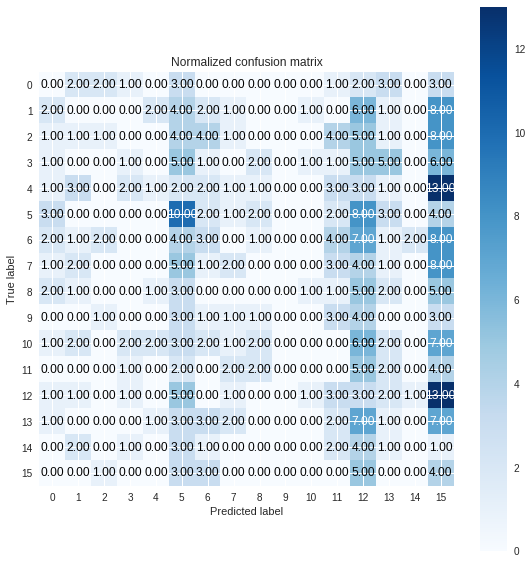

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    
    #if normalize:
    #    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = [8, 8]
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

class_indices = list(range(0, 16))
plot_confusion_matrix(gtruth, preds, classes=class_indices, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### [Bonus]
Figure out what is wrong with the test generator... 😖😤

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)
    
test_generator = test_datagen.flow_from_directory(directory=test_data_dir,
                                                  target_size=(img_height, img_width),
                                                  batch_size=btch_size,
                                                  class_mode=None,
                                                  shuffle=False)

Found 408 images belonging to 1 classes.


In [0]:
test_generator.reset()
pred = model.predict_generator(test_generator,
                               verbose=1,
                               steps=len(test_generator.filenames))

predicted_class_indices = np.argmax(pred, axis=1)

labels = (train_generator.class_indices)
labels = dict((v, k) for k, v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames

corrects = 0
total = 0
for pred in predictions:
    total += 1
    if pred in filename:
        corrects += 1
        
print(100 * corrects / total) 

408/408 [==============================] - 225s 551ms/step
22.89325842696629
